<a href="https://colab.research.google.com/github/yepedraza/mask-detection/blob/master/maskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Google Drive connection**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Libraries Import**

In [23]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

### **Data preprocessing**

In [3]:
directory = "/content/drive/MyDrive/Personal projects/mask-detect/annotations"
image_directory = "/content/drive/MyDrive/Personal projects/mask-detect/images"
df = pd.read_csv("/content/drive/MyDrive/Personal projects/mask-detect/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Personal projects/mask-detect/submission.csv")

Function for retrieve the JSON file containing the bounding box data in the training dataset.

In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

I explore the JSON data provided for the training

In [5]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))

Some constants creation

In [6]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}

Bounding box of faces extracted ando stored in a data list w/ mask/without mask labels for learning process

In [7]:
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

I look the amount of labeled data for each category

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


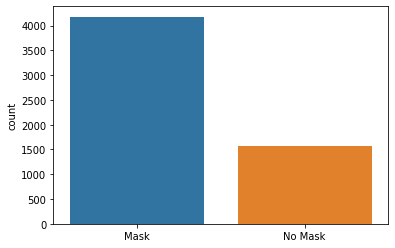

In [8]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

Data treatment and input/ouput creation

In [9]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

### **Model creation**

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                        

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("faceMask.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

In [13]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy'])

Using scikit-learn to split the data for validation

In [14]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

I use data augmentation for prevent overfitting

In [15]:
datagen = ImageDataGenerator(featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)

datagen.fit(xtrain)

In [17]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval),
                    callbacks=checkpoint
                    ).history

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.2794 - accuracy: 0.8822
Epoch 1: loss improved from 0.37993 to 0.27937, saving model to faceMask.h5
143/143 [==============================] - 22s 153ms/step - loss: 0.2794 - accuracy: 0.8822 - val_loss: 0.2240 - val_accuracy: 0.9052
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.8774
Epoch 2: loss did not improve from 0.27937
143/143 [==============================] - 20s 142ms/step - loss: 0.2923 - accuracy: 0.8774 - val_loss: 0.2058 - val_accuracy: 0.9148
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.2644 - accuracy: 0.8899
Epoch 3: loss improved from 0.27937 to 0.26441, saving model to faceMask.h5
143/143 [==============================] - 21s 148ms/step - loss: 0.2644 - accuracy: 0.8899 - val_loss: 0.2564 - val_accuracy: 0.8939
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.9008
Epoch 4: loss impro

### **Model parameters visualization**

In [28]:
def ParamsVisual(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))

    axL.plot(history['loss'], label="Loss (cce) - Training")
    axL.plot(history['val_loss'], label="Loss (cce) - Validation")
    axL.set_title('Model Loss')
    axL.set_xlabel('Epoch')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history['accuracy'], label="Accuracy - Training")
    axR.plot(history['val_accuracy'], label="Accuracy - Validation")
    axR.set_title('Model accuracy')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('Accuracy')
    axR.legend(loc='upper right')

    plt.show()

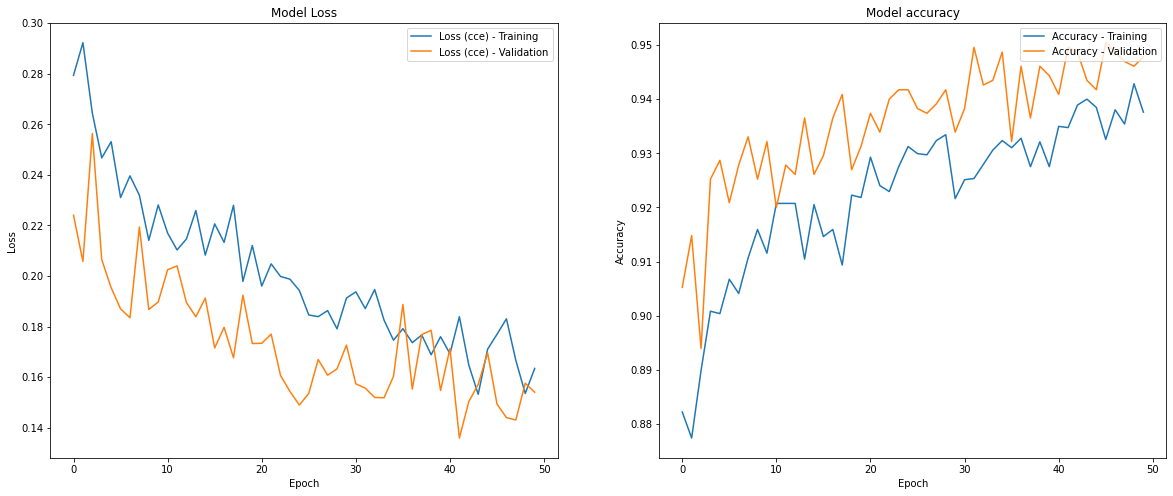

In [29]:
ParamsVisual(history)

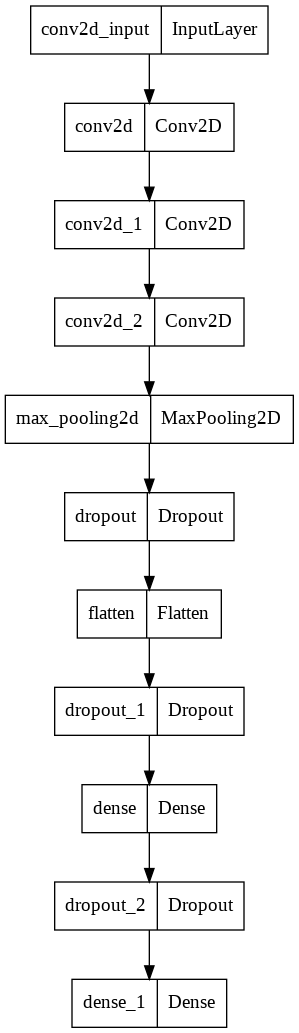

In [24]:
tf.keras.utils.plot_model(model, to_file='model.png')